In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, PauliFeatureMap
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit.circuit.library import TwoLocal

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import pennylane as qml
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector
qi = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))


In [3]:
class MultiHeadAttentionBase(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 num_heads: int,
                 dropout: float = 0.1,
                 mask=None,
                 use_bias=False):
        super(MultiHeadAttentionBase, self).__init__()

        assert embed_dim % num_heads == 0, f"Embedding dimension ({embed_dim}) should be divisible by number of heads ({num_heads})"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.d_k = embed_dim // num_heads  # projection dimensions
        self.k_linear = None
        self.q_linear = None
        self.v_linear = None
        self.combine_heads = None
        self.dropout = nn.Dropout(dropout)
        self.attn_weights = None
    
    def separate_heads(self, x):
        '''
        split into N heads
        from (batch_size, seq_len, embed_dim)
        to   (batch_size, seq_len, num_heads, embed_dim)
        then transpose (1,2) to (batch_size, num_heads, seq_len, embed_dim)
        to make mat mult straightforward for each head
        '''
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.num_heads, self.d_k)
        return x.transpose(1, 2)

    def attention(self, query, key, value, mask=None, dropout=None):
        '''
        Attention(Q, K, V) = softmax(Q K^T / sqrt(d_k))V
        '''
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_k)
        # see also: https://tensorchiefs.github.io/dlday2018/tutorial/einsum.html
        #scores = torch.einsum('bijh, bkjh -> bikh', query, key) / math.sqrt(self.d_k)
        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)
        scores = F.softmax(scores, dim=-1)
        if dropout is not None:
            scores = dropout(scores)
        attn = torch.matmul(scores, value)
        return attn, scores
    
    def downstream(self, query, key, value, batch_size, mask=None):
        Q = self.separate_heads(query)
        K = self.separate_heads(key)
        V = self.separate_heads(value)

        x, self.attn_weights = self.attention(Q, K, V, mask, dropout=self.dropout)

        concat = x.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)

        return concat
        # output = self.combine_heads(concat)
        # return output

    def forward(self, x, mask=None):
        raise NotImplementedError("Base class does not execute forward function.")



In [4]:
class MultiHeadAttentionQuantum(MultiHeadAttentionBase):
    def __init__(self,
                 embed_dim: int,
                 num_heads: int,
                 dropout=0.1,
                 mask=None,
                 use_bias=False,
                 n_qubits: int = 4,
                 n_qlayers: int = 1,
                 q_device="default.qubit",
                 ansatz_id=1):
        super(MultiHeadAttentionQuantum, self).__init__(embed_dim, num_heads, dropout=dropout, mask=mask, use_bias=use_bias)
        
        # todo: add intermediate layer to "dress" quantum circuit
        assert n_qubits == embed_dim, "Number of qubits ({n_qubits}) does not match embedding dim ({embed_dim})"

        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.q_device = q_device
        self.ansatz_id = ansatz_id
        if 'qulacs' in q_device:
            self.dev = qml.device(q_device, wires=self.n_qubits, gpu=True)
        elif 'braket' in q_device:
            self.dev = qml.device(q_device, wires=self.n_qubits, parallel=True)
        else:
            self.dev = qml.device(q_device, wires=self.n_qubits)


        if ansatz_id==1:
            def _circuit(inputs, weights):
                qml.templates.AngleEmbedding(inputs, wires=range(self.n_qubits))
                qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
                return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
        elif ansatz_id==2:
            def _circuit(inputs, weights):
                for i in range(len(inputs)):
                    qml.Hadamard(wires=i)
                inputs_arctan1 = np.arctan(inputs)
                inputs_arctan2 = np.arctan(inputs**2)
                qml.templates.AngleEmbedding(inputs_arctan1, wires=range(n_qubits),rotation='Y')
                qml.templates.AngleEmbedding(inputs_arctan2, wires=range(n_qubits),rotation='Z')
                for w in range(weights.shape[0]):
                  qml.broadcast(qml.CNOT,wires=range(n_qubits),pattern="ring")
                  for i in range(len(inputs)):
                    qml.CNOT(wires=[i, (i+2)%len(inputs)])
                  qml.templates.AngleEmbedding(weights[w], wires=range(n_qubits),rotation='Y')
                 
                return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

        self.qlayer = qml.QNode(_circuit, self.dev, interface="torch")
        self.weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {self.n_qubits})")

        print("before TorchLayer: ", self.k_linear, self.q_linear,self.v_linear)
        self.k_linear = qml.qnn.TorchLayer(self.qlayer, self.weight_shapes)
        self.q_linear = qml.qnn.TorchLayer(self.qlayer, self.weight_shapes)
        self.v_linear = qml.qnn.TorchLayer(self.qlayer, self.weight_shapes)
        self.combine_heads = qml.qnn.TorchLayer(self.qlayer, self.weight_shapes)
        print("after TorchLayer: ", self.k_linear, self.q_linear,self.v_linear)
        print("self.combine_heads: ",self.combine_heads)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, embed_dim = x.size()
        assert embed_dim == self.embed_dim, f"Input embedding ({embed_dim}) does not match layer embedding size ({self.embed_dim})"

        K = [self.k_linear(x[:, t, :]) for t in range(seq_len)]
        Q = [self.q_linear(x[:, t, :]) for t in range(seq_len)]
        V = [self.v_linear(x[:, t, :]) for t in range(seq_len)]
        print("KQV", len(K),K[0].size())
        K = torch.Tensor(pad_sequence(K))
        Q = torch.Tensor(pad_sequence(Q))
        V = torch.Tensor(pad_sequence(V))

        x = self.downstream(Q, K, V, batch_size, mask)
        print(x.size())
        output = [self.combine_heads(x[:, t, :]) for t in range(seq_len)]
        output = torch.Tensor(pad_sequence(output))
        return output

In [5]:
class MultiHeadAttentionQuantum_qiskit(MultiHeadAttentionBase):
    def __init__(self,
                 embed_dim: int,
                 num_heads: int,
                 dropout=0.1,
                 mask=None,
                 use_bias=False,
                 n_qubits: int = 4,
                 n_qlayers: int = 1,
                 q_device="default.qubit",
                 ansatz_id=1):
        super(MultiHeadAttentionQuantum_qiskit, self).__init__(embed_dim, num_heads, dropout=dropout, mask=mask, use_bias=use_bias)
        
        # todo: add intermediate layer to "dress" quantum circuit
        assert n_qubits == embed_dim, "Number of qubits ({n_qubits}) does not match embedding dim ({embed_dim})"

        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.q_device = q_device
        self.ansatz_id = ansatz_id
        if 'qulacs' in q_device:
            self.dev = qml.device(q_device, wires=self.n_qubits, gpu=True)
        elif 'braket' in q_device:
            self.dev = qml.device(q_device, wires=self.n_qubits, parallel=True)
        else:
            self.dev = qml.device(q_device, wires=self.n_qubits)


        if ansatz_id==1:
#             def _circuit(inputs, weights):
#                 qml.templates.AngleEmbedding(inputs, wires=range(self.n_qubits))
#                 qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
#                 return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
            qc_encode = TwoLocal(
                num_qubits=self.n_qubits,
                rotation_blocks=["rx"],
                reps=1,
                parameter_prefix = "x",
                skip_final_rotation_layer=True,
            )#.bind_parameters(inputs)
            qc_weight = TwoLocal(
                num_qubits=self.n_qubits,
                rotation_blocks=["rx"],
                entanglement_blocks="cx",
                entanglement="circular",
                reps=self.n_qlayers, # if input encoding is also repeated, fix this line
                skip_final_rotation_layer=True,
                parameter_prefix = "w",
            )#.bind_parameters(weights.reshape(-1))
            
            qc_sfn1 = StateFn(qc_encode.compose(qc_weight))
            op3 = ListOp(
                [
                    ~StateFn(PauliSumOp.from_list([("I" * i + "Z" + "I" * (self.n_qubits - i - 1), 1)]))@qc_sfn1
                    for i in range(self.n_qubits)
                ]
            )

#             params1 = [Parameter('input1'), Parameter('weight1')]
            params_in = [p for p in qc_sfn1.parameters if "x" in p.name]
            params_in = sorted(params_in, key=lambda p: p.name)
            params_weight = [p for p in qc_sfn1.parameters if "w" in p.name]
            params_weight = sorted(params_weight, key=lambda p: p.name)
            
            qnn4 = OpflowQNN(op3, params_in, params_weight,  gradient=Gradient(),exp_val=AerPauliExpectation(), quantum_instance=qi)

#             qnn4 = TwoLayerQNN(self.n_qubits, qc_encode, qc_weight, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi)
#         self.qlayer = qml.QNode(_circuit, self.dev, interface="torch")

        elif ansatz_id==2:
            def _circuit(inputs, weights):
                for i in range(len(inputs)):
                    qml.Hadamard(wires=i)
                inputs_arctan1 = np.arctan(inputs)
                inputs_arctan2 = np.arctan(inputs**2)
                qml.templates.AngleEmbedding(inputs_arctan1, wires=range(n_qubits),rotation='Y')
                qml.templates.AngleEmbedding(inputs_arctan2, wires=range(n_qubits),rotation='Z')
                for w in range(weights.shape[0]):
                    qml.broadcast(qml.CNOT,wires=range(n_qubits),pattern="ring")
                for i in range(len(inputs)):
                    qml.CNOT(wires=[i, (i+2)%len(inputs)])
                qml.templates.AngleEmbedding(weights[w], wires=range(n_qubits),rotation='Y')
                 
                return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

#         self.qlayer = qml.QNode(_circuit, self.dev, interface="torch")
#         self.qlayer = TorchConnector(qnn4)
        self.weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {self.n_qubits})")

        print("before TorchLayer: ", self.k_linear, self.q_linear,self.v_linear)
#         print("self.qlayer, self.weight_shapes",self.qlayer, self.weight_shapes)
#         self.k_linear = qml.qnn.TorchLayer(self.qlayer, self.weight_shapes)
#         self.q_linear = qml.qnn.TorchLayer(self.qlayer, self.weight_shapes)
#         self.v_linear = qml.qnn.TorchLayer(self.qlayer, self.weight_shapes)
#         self.combine_heads = qml.qnn.TorchLayer(self.qlayer, self.weight_shapes)
        self.k_linear =  TorchConnector(qnn4)
        self.q_linear =  TorchConnector(qnn4)
        self.v_linear =  TorchConnector(qnn4)
        self.combine_heads =  TorchConnector(qnn4)
        print("after TorchLayer: ", self.k_linear, self.q_linear,self.v_linear)
        print("self.combine_heads: ",self.combine_heads)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, embed_dim = x.size()
        assert embed_dim == self.embed_dim, f"Input embedding ({embed_dim}) does not match layer embedding size ({self.embed_dim})"

        K = [self.k_linear(x[:, t, :]) for t in range(seq_len)]
        Q = [self.q_linear(x[:, t, :]) for t in range(seq_len)]
        V = [self.v_linear(x[:, t, :]) for t in range(seq_len)]
        print("KQV", len(K),K[0].size())
        K = torch.Tensor(pad_sequence(K))
        Q = torch.Tensor(pad_sequence(Q))
        V = torch.Tensor(pad_sequence(V))

        x = self.downstream(Q, K, V, batch_size, mask)
        print("x size",x.size())
        output = [self.combine_heads(x[:, t, :]) for t in range(seq_len)]
        output = torch.Tensor(pad_sequence(output))
        return output

In [6]:
torch.manual_seed(0)
batch_size, seq_len, embed_dim  = 50, 1, 1
randarray = torch.rand(batch_size, seq_len, embed_dim)*2*np.pi
print(type(randarray))
# randarray,ind = torch.sort(randarray,dim=0)
randarray = torch.linspace(0, 2*np.pi, steps=batch_size).resize(batch_size, seq_len, embed_dim)
print(type(randarray))
print(randarray)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor([[[0.0000]],

        [[0.1282]],

        [[0.2565]],

        [[0.3847]],

        [[0.5129]],

        [[0.6411]],

        [[0.7694]],

        [[0.8976]],

        [[1.0258]],

        [[1.1541]],

        [[1.2823]],

        [[1.4105]],

        [[1.5387]],

        [[1.6670]],

        [[1.7952]],

        [[1.9234]],

        [[2.0517]],

        [[2.1799]],

        [[2.3081]],

        [[2.4363]],

        [[2.5646]],

        [[2.6928]],

        [[2.8210]],

        [[2.9493]],

        [[3.0775]],

        [[3.2057]],

        [[3.3339]],

        [[3.4622]],

        [[3.5904]],

        [[3.7186]],

        [[3.8468]],

        [[3.9751]],

        [[4.1033]],

        [[4.2315]],

        [[4.3598]],

        [[4.4880]],

        [[4.6162]],

        [[4.7444]],

        [[4.8727]],

        [[5.0009]],

        [[5.1291]],

        [[5.2574]],

        [[5.3856]],

        [[5.5138]],

        [[5.6420]],

        [

/Users/y.n./.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [7]:
qubit_num = 3
qmodel_t = MultiHeadAttentionQuantum(embed_dim=embed_dim, num_heads=embed_dim, n_qubits =embed_dim)

val_t = qmodel_t.forward(randarray)
val_t

weight_shapes = (n_qlayers, n_qubits) = (1, 1)
before TorchLayer:  None None None
after TorchLayer:  <Quantum Torch Layer: func=_circuit> <Quantum Torch Layer: func=_circuit> <Quantum Torch Layer: func=_circuit>
self.combine_heads:  <Quantum Torch Layer: func=_circuit>
KQV 1 torch.Size([50, 1])
torch.Size([50, 1, 1])


tensor([[[-0.9975]],

        [[-0.9784]],

        [[-0.9396]],

        [[-0.8815]],

        [[-0.8062]],

        [[-0.7172]],

        [[-0.6192]],

        [[-0.5170]],

        [[-0.4160]],

        [[-0.3206]],

        [[-0.2350]],

        [[-0.1623]],

        [[-0.1048]],

        [[-0.0639]],

        [[-0.0408]],

        [[-0.0357]],

        [[-0.0489]],

        [[-0.0801]],

        [[-0.1285]],

        [[-0.1931]],

        [[-0.2719]],

        [[-0.3623]],

        [[-0.4607]],

        [[-0.5629]],

        [[-0.6638]],

        [[-0.7584]],

        [[-0.8418]],

        [[-0.9097]],

        [[-0.9594]],

        [[-0.9893]],

        [[-0.9999]],

        [[-0.9931]],

        [[-0.9720]],

        [[-0.9408]],

        [[-0.9039]],

        [[-0.8659]],

        [[-0.8309]],

        [[-0.8023]],

        [[-0.7827]],

        [[-0.7738]],

        [[-0.7764]],

        [[-0.9113]],

        [[-0.8141]],

        [[-0.8460]],

        [[-0.8828]],

        [[

In [8]:
qmodel_t.attn_weights#.size()

tensor([[[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[1.1111]]],


        [[[0.000

In [118]:
# qmodel_t_ibm.attn_weights = qmodel_t.attn_weights
# qmodel_t_ibm.forward(randarray)
# qmodel_t_ibm.attn_weights#.size()

In [130]:
import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'


qmodel_t_ibm = MultiHeadAttentionQuantum_qiskit(embed_dim=embed_dim, num_heads=embed_dim, n_qubits =embed_dim)
# qmodel_t_ibm.attn_weights = qmodel_t.attn_weights

val_q = qmodel_t_ibm.forward(randarray)
val_q = qmodel_t_ibm.forward(randarray)
val_q = qmodel_t_ibm.forward(randarray)

val_q

weight_shapes = (n_qlayers, n_qubits) = (1, 1)
before TorchLayer:  None None None
after TorchLayer:  TorchConnector() TorchConnector() TorchConnector()
self.combine_heads:  TorchConnector()
KQV 1 torch.Size([50, 1])
x size torch.Size([50, 1, 1])
KQV 1 torch.Size([50, 1])
x size torch.Size([50, 1, 1])
KQV 1 torch.Size([50, 1])
x size torch.Size([50, 1, 1])


tensor([[[0.5972]],

        [[0.5852]],

        [[0.5880]],

        [[0.6053]],

        [[0.6362]],

        [[0.6788]],

        [[0.7304]],

        [[0.9865]],

        [[0.8459]],

        [[0.9008]],

        [[0.9474]],

        [[0.9812]],

        [[0.9984]],

        [[0.9964]],

        [[0.9744]],

        [[0.9330]],

        [[0.8747]],

        [[0.9865]],

        [[0.7227]],

        [[0.6388]],

        [[0.5562]],

        [[0.4796]],

        [[0.4126]],

        [[0.3585]],

        [[0.3193]],

        [[0.2966]],

        [[0.2912]],

        [[0.3031]],

        [[0.3321]],

        [[0.3770]],

        [[0.4362]],

        [[0.5072]],

        [[0.9865]],

        [[0.9865]],

        [[0.7533]],

        [[0.8310]],

        [[0.8982]],

        [[0.9506]],

        [[0.9850]],

        [[0.9995]],

        [[0.9941]],

        [[0.9704]],

        [[0.9313]],

        [[0.8811]],

        [[0.8243]],

        [[0.7658]],

        [[0.7103]],

        [[0.6

KQV 1 torch.Size([50, 1])
x size torch.Size([50, 1, 1])
KQV 1 torch.Size([50, 1])
x size torch.Size([50, 1, 1])
KQV 1 torch.Size([50, 1])
x size torch.Size([50, 1, 1])


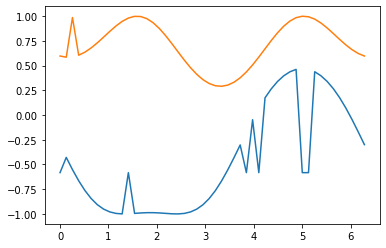

In [134]:
plt.plot(randarray[:,0,0],val_t[:,0,0].detach().numpy())
plt.plot(randarray[:,0,0],val_q[:,0,0].detach().numpy())

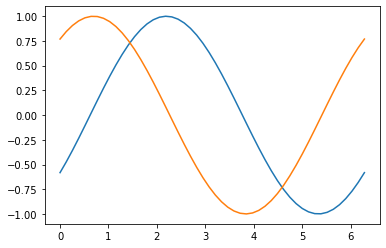

In [111]:
val1_q = qmodel_t.combine_heads(randarray[:,:,0])
val2_q = qmodel_t_ibm.combine_heads(randarray[:,:,0])
plt.plot(randarray[:,0,0],val1_q[:].detach().numpy())
plt.plot(randarray[:,0,0],val2_q[:].detach().numpy())

# debug

In [7]:
num_qubits = 3
observable = PauliSumOp.from_list([('Z'*num_qubits, 1),('Y'*num_qubits, 1)])
print(observable)
op2 = ListOp([observable, observable])
print(op2)

1.0 * ZZZ
+ 1.0 * YYY
ListOp([
  1.0 * ZZZ
  + 1.0 * YYY,
  1.0 * ZZZ
  + 1.0 * YYY
])


In [12]:
n_qubits=3
n_qlayers=2

qc_encode = TwoLocal(
    num_qubits=n_qubits,
    rotation_blocks=["rx"],
    reps=1,
    parameter_prefix = "x",
    skip_final_rotation_layer=True,
)#.bind_parameters(inputs)
qc_weight = TwoLocal(
    num_qubits=n_qubits,
    rotation_blocks=["rx"],
    entanglement_blocks="cx",
    entanglement="circular",
    reps=n_qlayers, # if input encoding is also repeated, fix this line
    skip_final_rotation_layer=True,
)#.bind_parameters(weights.reshape(-1))


qc_sfn1 = StateFn(qc_encode.compose(qc_weight))

op3 = ListOp(
    [
#         ~StateFn(PauliSumOp.from_list([("I" * i + "Z" + "I" * (num_qubits - i - 1), 1)]))@qc_sfn1
        PauliSumOp.from_list([("I" * i + "Z" + "I" * (n_qubits - i - 1), 1)])
#         PauliSumOp.from_list([("Z"*num_qubits, 1)]) # debug
        for i in range(n_qubits)
    ]
)

qnn4 = TwoLayerQNN(n_qubits, qc_encode, qc_weight, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi,observable=op3)

TorchConnector(qnn4)

TorchConnector()

In [14]:
op3 = ListOp(
    [
        ~StateFn(PauliSumOp.from_list([("I" * i + "Z" + "I" * (n_qubits - i - 1), 1)]))@qc_sfn1
#         PauliSumOp.from_list([("I" * i + "Z" + "I" * (num_qubits - i - 1), 1)])
#         PauliSumOp.from_list([("Z"*num_qubits, 1)]) # debug
        for i in range(n_qubits)
    ]
)

qnn5 = OpflowQNN(op3, [params1[0]], [params1[1]],  gradient=Gradient(),exp_val=AerPauliExpectation(), quantum_instance=qi)
print(qnn5.operator)

NameError: name 'params1' is not defined

In [27]:
dir(qc_sfn1)
params = list(qc_sfn1.parameters)
params[0].name
# dir(params[0])
# params

'θ[5]'

In [112]:
op2 = ListOp([op1, op1])
qnn2 = OpflowQNN(op1, [params1[0]], [params1[1]], expval, gradient, qi_sv)


In [77]:
params1 = [Parameter('input1'), Parameter('weight1')]

gradient=Gradient()
qnn2 = OpflowQNN(op2, [params1[0]], [params1[1]],  gradient=Gradient(),exp_val=AerPauliExpectation(), quantum_instance=qi)

In [116]:
print(qnn4.operator)

ComposedOp([
  OperatorMeasurement(ListOp([
    ComposedOp([
      CircuitMeasurement(
           ┌─────────────────────────────────────────────┐»
      q_0: ┤0                                            ├»
           │                                             │»
      q_1: ┤1 TwoLocal_dg(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5]) ├»
           │                                             │»
      q_2: ┤2                                            ├»
           └─────────────────────────────────────────────┘»
      «     ┌──────────────────────────────┐
      «q_0: ┤0                             ├
      «     │                              │
      «q_1: ┤1 TwoLocal_dg(x[0],x[1],x[2]) ├
      «     │                              │
      «q_2: ┤2                             ├
      «     └──────────────────────────────┘
      ),
      OperatorStateFn(1.0 * ZII)
    ]),
    ComposedOp([
      CircuitMeasurement(
           ┌─────────────────────────────────────────────┐»
      q_0: ┤0            

In [72]:
num_qubits = 3
op3 = ListOp(
    [
        PauliSumOp.from_list([("I" * i + "Z" + "I" * (num_qubits - i - 1), 1)])
        for i in range(num_qubits)
    ]
)
print(op3)

ListOp([
  1.0 * ZII,
  1.0 * IZI,
  1.0 * IIZ
])


In [38]:
qml.qnn.TorchLayer(self.qlayer, self.weight_shapes)

NameError: name 'self' is not defined

[-0.14257812 -0.140625  ]


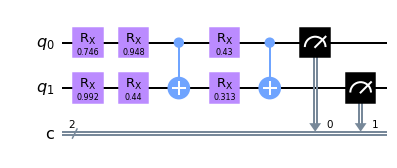

In [99]:
n_qubits = 2
inputs=np.random.rand(2)
weights = np.random.rand(2,n_qubits)

# print(qml.templates.AngleEmbedding(inputs, wires=range(n_qubits)))
# print(qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits)))

dev_2 = qml.device("qiskit.aer", wires=n_qubits)
@qml.qnode(dev_2)
def _circuit_draw(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
#     qml.templates.AngleEmbedding(inputs, wires=range(n_qubits),rotation='X')
#     qml.templates.AngleEmbedding(inputs, wires=range(n_qubits),rotation='Y')
#     qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

print(_circuit_draw(inputs, weights)) 
dev_2._circuit.draw("mpl",fold=1)

In [ ]:
# qiskit
#  output = [<Z1Z2>]   :|00>, |11> → <Z1Z2>=1
# pennlyane
# output [<Z1>, <Z2>] :  |00> → =[1,1] , |11> → =[-1,-1]

In [ ]:
# <00|Z1Z2|00>=<00|00>=1
# <11|Z1Z2|11>=<11|(-1)(-1)|11>=1
# <01|Z1Z2|01>=<00|00>=1
# <10|Z1Z2|10>=<11|(-1)(-1)|11>=1

In [100]:
# qml.qnn.TorchLayer(qmodel_t.qlayer, qmodel_t.weight_shapes)(randarray[:,1,:])
qmodel_t.k_linear(randarray[:,1,:])
# plt.plot(qmodel_t.k_linear(randarray[:,1,:])[:,0].detach().numpy())

tensor([[ 0.0149,  0.0366, -0.0135],
        [-0.0007, -0.0012,  0.0007],
        [-0.0724, -0.3425,  0.0723],
        [-0.0068, -0.0464,  0.0064],
        [ 0.0965,  0.1397, -0.0833],
        [ 0.1627,  0.1873, -0.1557],
        [-0.1235, -0.1748,  0.1216],
        [-0.0982, -0.4275,  0.0931],
        [-0.1480, -0.3120,  0.1344],
        [ 0.1345,  0.1736, -0.1210],
        [-0.2254, -0.4124,  0.2246],
        [ 0.1481,  0.2114, -0.1355],
        [-0.2023, -0.2317,  0.1882],
        [-0.4303, -0.4716,  0.3998],
        [-0.2444, -0.3233,  0.2339],
        [ 0.2495,  0.3335, -0.2477],
        [-0.1020, -0.5472,  0.0957],
        [ 0.1740,  0.2218, -0.1735],
        [ 0.0089,  0.1474, -0.0087],
        [-0.0858, -0.2231,  0.0857],
        [ 0.2327,  0.3168, -0.2293],
        [-0.0181, -0.0408,  0.0161],
        [-0.0873, -0.1643,  0.0867],
        [-0.3061, -0.5681,  0.2964],
        [ 0.0750,  0.0959, -0.0749],
        [-0.3440, -0.4012,  0.3365],
        [-0.0321, -0.0539,  0.0309],
 

In [60]:
qmodel_t_ibm.k_linear(randarray[:,1,:])

tensor([[ 0.5902],
        [-0.1327],
        [ 0.3538],
        [ 0.2423],
        [ 0.4627],
        [-0.1106],
        [ 0.6647],
        [-0.1679],
        [ 0.6680],
        [ 0.0210],
        [ 0.6670],
        [-0.0299],
        [-0.2316],
        [ 0.5292],
        [ 0.4983],
        [ 0.1120],
        [ 0.1469],
        [ 0.4318],
        [-0.1769],
        [ 0.5448],
        [ 0.6904],
        [ 0.4726],
        [ 0.0104],
        [ 0.5544],
        [ 0.5237],
        [ 0.3794],
        [ 0.6044],
        [-0.0334],
        [ 0.6326],
        [ 0.1442],
        [ 0.0267],
        [ 0.4854],
        [ 0.1558],
        [ 0.3095],
        [-0.0546],
        [ 0.2950],
        [ 0.2634],
        [ 0.6329],
        [ 0.6784],
        [ 0.4494],
        [ 0.6404],
        [ 0.0749],
        [ 0.4504],
        [-0.0530],
        [ 0.6189],
        [ 0.1234],
        [ 0.3602],
        [-0.0787],
        [ 0.5129],
        [ 0.2708]], grad_fn=<_TorchNNFunctionBackward>)

In [151]:
qmodel_t_ibm.k_linear.__dict__

{'training': True,
 '_parameters': OrderedDict([('weight', Parameter containing:
               tensor([-0.5241,  0.8075], requires_grad=True)),
              ('_weights',
               Parameter containing:
               tensor([-0.5241,  0.8075], requires_grad=True))]),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 '_neural_network': <qiskit_machine_learning.neural_networks.two_layer_qnn.TwoLayerQNN at 0x7f85a25881d0>,
 '_sparse': None}

In [123]:
randarray

tensor([[[0.4963, 0.7682, 0.0885],
         [0.1320, 0.3074, 0.6341]],

        [[0.4901, 0.8964, 0.4556],
         [0.6323, 0.3489, 0.4017]],

        [[0.0223, 0.1689, 0.2939],
         [0.5185, 0.6977, 0.8000]],

        [[0.1610, 0.2823, 0.6816],
         [0.9152, 0.3971, 0.8742]],

        [[0.4194, 0.5529, 0.9527],
         [0.0362, 0.1852, 0.3734]],

        [[0.3051, 0.9320, 0.1759],
         [0.2698, 0.1507, 0.0317]],

        [[0.2081, 0.9298, 0.7231],
         [0.7423, 0.5263, 0.2437]],

        [[0.5846, 0.0332, 0.1387],
         [0.2422, 0.8155, 0.7932]],

        [[0.2783, 0.4820, 0.8198],
         [0.9971, 0.6984, 0.5675]],

        [[0.8352, 0.2056, 0.5932],
         [0.1123, 0.1535, 0.2417]],

        [[0.7262, 0.7011, 0.2038],
         [0.6511, 0.7745, 0.4369]],

        [[0.5191, 0.6159, 0.8102],
         [0.9801, 0.1147, 0.3168]],

        [[0.6965, 0.9143, 0.9351],
         [0.9412, 0.5995, 0.0652]],

        [[0.5460, 0.1872, 0.0340],
         [0.9442, 0.8802, 0.0

In [149]:
n_qubits = 4
n_qlayers = 1
dev =  qml.device("default.qubit", wires=n_qubits)

def _circuit(inputs, weights):
                qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
                qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
                return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
qlayer = qml.QNode(_circuit, dev, interface="torch")
weight_shapes = {"weights": (n_qlayers, n_qubits)}


batch_size, seq_len, embed_dim  = 50, 2, n_qubits
randarray2 = torch.rand(batch_size, seq_len, embed_dim)

qml.qnn.TorchLayer(qlayer, weight_shapes)(randarray2[:5,1,:1])


tensor([[-0.5486, -0.5036,  0.2834, -0.2764],
        [-0.5486, -0.5157,  0.2902, -0.2830],
        [-0.5486, -0.7781,  0.4379, -0.4270],
        [-0.5486, -0.6874,  0.3868, -0.3772],
        [-0.5486, -0.8548,  0.4811, -0.4691]], grad_fn=<StackBackward>)

In [146]:
qlayer.__dict__

{'mutable': True,
 'func': <function __main__._circuit(inputs, weights)>,
 '_original_device': <DefaultQubit device (wires=2, shots=1000) at 0x7f85a35424d0>,
 'qtape': <TorchQuantumTape: wires=[0, 1], params=2>,
 'qfunc_output': [expval(PauliZ(wires=[0])), expval(PauliZ(wires=[1]))],
 'diff_method': 'best',
 '_tape': pennylane.tape.tapes.qubit_param_shift.QubitParamShiftTape,
 'interface': 'torch',
 'device': <DefaultQubit device (wires=2, shots=1000) at 0x7f85a35424d0>,
 'diff_options': {'method': 'best'},
 'dtype': torch.float64,
 'max_expansion': 10}

In [135]:
randarray2[:5,1,:1]

tensor([[0.7153],
        [0.8691],
        [0.4464],
        [0.7818],
        [0.3029]])

In [144]:
sample = torch.tensor([[0], [0.8691],  [0.4464], [0.7818], [0.3029]])
qml.qnn.TorchLayer(qlayer, weight_shapes)(sample)


tensor([[ 0.5403, -0.1575],
        [ 0.9914, -0.2890],
        [ 0.8506, -0.2479],
        [ 0.9763, -0.2845],
        [ 0.7667, -0.2235]], grad_fn=<StackBackward>)

# from Tutorial

In [53]:
# set method to calculcate expected values
expval = AerPauliExpectation()

# define gradient method
gradient = Gradient()

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# we set shots to 10 as this will determine the number of samples later on.
qi_qasm = QuantumInstance(Aer.get_backend('aer_simulator'), shots=10)

In [54]:

# construct parametrized circuit
params1 = [Parameter('input1'), Parameter('weight1')]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc_sfn1 = StateFn(qc1)

# construct cost operator
H1 = StateFn(PauliSumOp.from_list([('Z', 1.0), ('X', 1.0)]))

# combine operator and circuit to objective function
op1 = ~H1 @ qc_sfn1
print(op1)

ComposedOp([
  OperatorMeasurement(1.0 * Z
  + 1.0 * X),
  CircuitStateFn(
       ┌───┐┌────────────┐┌─────────────┐
  q_0: ┤ H ├┤ Ry(input1) ├┤ Rx(weight1) ├
       └───┘└────────────┘└─────────────┘
  )
])


In [57]:
# construct OpflowQNN with the operator, the input parameters, the weight parameters,
# the expected value, gradient, and quantum instance.
qnn1 = OpflowQNN(op1, [params1[0]], [params1[1]], expval, gradient, qi_sv)

In [58]:
# define (random) input and weights
input1 = np.random.rand(qnn1.num_inputs)
weights1 = np.random.rand(qnn1.num_weights)

In [ ]:
op2 = ListOp([op1, op1])
qnn2 = OpflowQNN(op2, [params1[0]], [params1[1]], expval, gradient, qi_sv)

# QNN forward pass
qnn2.forward(input1, weights1)

In [135]:
# Define QNN
feature_map = ZZFeatureMap(2)
ansatz = RealAmplitudes(2, reps=1)
# REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
qnn4 = TwoLayerQNN(2, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi,observable=op1)
print(qnn4.operator)

ComposedOp([
  OperatorMeasurement(ListOp([
    CircuitMeasurement(
                                                     
    q_0: ────────────────────────────────────────────
         ┌──────────────────┐┌─────────────────┐┌───┐
    q_1: ┤ Rx(-1.0*weight1) ├┤ Ry(-1.0*input1) ├┤ H ├
         └──────────────────┘└─────────────────┘└───┘
    ),
    OperatorStateFn(1.0 * ZI
    + 1.0 * XI)
  ])),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])


In [132]:
# qnn4._construct_gradient_operator()
qnn4._gradient or Gradient()
qnn4._input_gradients
params = qnn4._input_params + qnn4._weight_params
gradient.convert(qnn4._operator, params)

ValueError: This operator was not properly decomposed. By this point, all operator measurements should contain single operators, otherwise the coefficient gradients will not be handled properly.

In [98]:
qnn4 = TwoLayerQNN(n_qubits, qc_encode, qc_weight, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi,observable="XI0")
print(qnn4.operator)

ComposedOp([
  DictMeasurement({'XI0': 1}),
  CircuitStateFn(
       ┌───────────────────────────┐┌──────────────────────────────────────────┐
  q_0: ┤0                          ├┤0                                         ├
       │                           ││                                          │
  q_1: ┤1 TwoLocal(x[0],x[1],x[2]) ├┤1 TwoLocal(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5]) ├
       │                           ││                                          │
  q_2: ┤2                          ├┤2                                         ├
       └───────────────────────────┘└──────────────────────────────────────────┘
  )
])
